# Análise do comportamento dos usuários de aplicativo #

Neste projeto, vamos analisar o comportamento dos usuários de um aplicativo de venda de produtos alimentícios. Vamos investigar o funil de vendas da empresa e analisar os resultados de um teste A/A/B para diferentes fontes no aplicativo. Para começar vamos carregar os dados disponíveis e prepará-los para a análise.

## Pré-processamento ##

Vamos começar carregando algumas bibliotecas de Python que serão úteis no projeto:

In [1]:
# Biblioteca para criação e manipulação de DataFrames
import pandas as pd

# Biblioteca para operações matemáticas complexas
import numpy as np

# Bibliotecas para criação de gráficos
import matplotlib.pyplot as plt
from plotly import graph_objs as go

# Bibliotecas para operações estatísticas
from scipy import stats as st

Agora vamos carregar nossos dados, que estão no arquivo ``logs_exp_us.csv``, na forma de um DataFrame na variável ``data``.

In [2]:
data = pd.read_csv('C:/Users/atlas/documents/projetos_dados/datasets/logs_exp_us.csv', sep='\t')

# Imprimindo as pimeiras linhas
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Vamos ver as informações gerais sobre nossa tabela:

In [3]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.9 MB


Vemos que não há valores ausentes. Mas vamos procurar por linhas duplicadas:

In [4]:
data[data.duplicated()]

,EventName,DeviceIDHash,EventTimestamp,ExpId
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


Parece que existem várias linhas duplicadas. Provavelmente algum erro no momento da captura dos dados os duplicou. Vamos retirá-los de nossa tabela:

In [5]:
data = data.drop_duplicates().reset_index(drop=True)

# Conferindo os dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       243713 non-null  object
 1   DeviceIDHash    243713 non-null  int64 
 2   EventTimestamp  243713 non-null  int64 
 3   ExpId           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Apagamos as linhas duplicadas. Agora vamos alterar os nomes das colunas para minúsculas para facilitar os cálculos:

In [6]:
data.columns = data.columns.str.lower()

# Conferinodas primeiras linhas
data.head()

,eventname,deviceidhash,eventtimestamp,expid
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


A coluna ``eventtimestamp`` está no formato **TimeStamp**, vamos convertê-la para o formato data-hora e salvar o resultado na coluna ``date_time`` e criar uma coluna ``date`` com apenas a data:

In [7]:
# Criando a coluna com as informações de data e hora
data['date_time'] = pd.to_datetime(data['eventtimestamp'], unit='s')

# Criando a coluna com as informações da data
data['date'] = data['date_time'].dt.floor('1D')

# Imprimindo as primeiras linhas
data.head()

,eventname,deviceidhash,eventtimestamp,expid,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


## Análise inicial dos dados ##

Vamos estudar os dados para descobrir como a quantidade de eventos se distribui e qual o período coberto pelos dados. Primeiro, vamos ver a média de eventos por dia:

In [8]:
# Agrupando os dados por data na tabela "daily_events"
daily_events = data.groupby('date', as_index=False).agg({'eventname':'count'})

# Renomeando as colunas
daily_events.columns = ['date', 'events']

# Obtendo algumas estatísticas sobre o eventos
daily_events['events'].describe()

count       14.000000
mean     17408.071429
std      17703.817817
min          9.000000
25%        124.750000
50%      16563.000000
75%      34986.000000
max      36141.000000
Name: events, dtype: float64

Vemos que temos dados de 14 dias. A quantidade média de eventos é 17408,07, próxima da mediana 16563. 75% dos dias têm até 34986 eventos. Vamos ver quantos eventos ocorreram no total:

In [9]:
daily_events['events'].sum()

243713

No período que os dados cobrem, tivemos 243713 eventos. Vamos ver como a quantidade de eventos se divide por usuário:

In [10]:
# Agrupando os dados por usuário
user_events = data.groupby('deviceidhash', as_index=False).agg({'eventname':'count'})

# Renomeando as colunas
user_events.columns = ['user', 'events']

# Obtendo algumas estatísticas sobre os eventos
user_events['events'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: events, dtype: float64

Temos 7551 usuários nos nossos dados. A média de eventos por usuário é 32,27, já a mediana é de 20, o que pode indicar que alguns usuários mais assíduos estão distorcendo a média para cima. Temos que 75% dos usuários realizaram até 37 eventos.

Precisamos ver como os eventos se distribuem por cada dia. Para isso, vamos imprimir nossa tabela ``daily_events``:

In [11]:
daily_events

,date,events
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


Os eventos vão de 25/07/2019 até 07/08/2019. O que vemos é que até o dia 31/07/2019, exatamente a primeira semana dos dados, a quantidade de eventos é bem inferior ao período da segunda semana, onde os números permanecem na casa dos 30000. Provavelmente apenas a segunda semana resgistra o conjunto completo de eventos, logo é interessante criar um DataFrame sem os dados da primeria semana, para evitar distorções na análise.

In [12]:
# Criando o DataFrame "data" apenas com dados a partir de 01/08/2019
data_ = data[data['date']>'2019-07-31'].reset_index(drop=True)

# Imprimindo as primeiras linhas
data_.head()

,eventname,deviceidhash,eventtimestamp,expid,date_time,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Vamos calcular qual o percentual de usuários foram perdidos com a exclusão dessa parte dos dados:

In [13]:
((data['deviceidhash'].nunique() - data_['deviceidhash'].nunique()) / data['deviceidhash'].nunique()) * 100

0.22513574361011784

Perdemos apenas 0,22% dos usuários, uma diferença razoavelmente pequena. Vamos ver o percentual de eventos perdidos:

In [14]:
((data['eventname'].count() - data_['eventname'].count()) / data['eventname'].count()) * 100

1.159560630741897

Os eventos perdidos representavam apenas 1,16% do total, o que também não é uma perda muito significativa. Logo, faz sentido retirar esses dados dos nossos cálculos, uma vez que representam uma fatia pequena do total e têm o potencial de distorcer nossas análises. Porém, precisamos verificar se sobraram usuários suficientes de cada grupo do experimento A/A/B.

In [15]:
data_['expid'].value_counts()

248    84563
246    79302
247    77022
Name: expid, dtype: int64

Continuamos com quantidades similares de usuários entre os três grupos do experimento, podemos passar para a fase seguinte de nossa análise.

## Análise do funil de eventos ##

Agora, vamos estudar a frequência de ocorrência dos eventos, a quantidade de usuários que executou cada ação e a ordem em que os eventos ocorreram. Com essas informações, vamos construir o funil de eventos e calcular as etapas em que mais usuários são perdidos.

Para começar, vamos ver quais eventos temos e qual sua frequência:

In [16]:
data_['eventname'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: eventname, dtype: int64

*MainScreenAppear* é o evento mais comum, o que faz sentido, é esperado que o aparecimento da tela principal seja o evento mais frequente para os usuários. Em seguida temos os aparecimentos das telas de oferta, *OffersScreenAppear* e do carrinho, *CartScreenAppear*. Então temos a tela de pagamento, *PaymentScreenSuccessful*, com um ocorrência um pouco menor, e por último, o *Tutorial*, sendo acionado por bem poucos usuários.

Vamos descobrir agora a quantidade de usuários únicos que realizaram cada um dos eventos.

In [17]:
# Criando uma tabela com as informações
events_users = data_.groupby('eventname', as_index=False).agg({'deviceidhash':'nunique'}).sort_values(by='deviceidhash', ascending=False)

# Imprimindo a tabela
events_users

,eventname,deviceidhash
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


As posições dos eventos se mantém a mesma, agora com números significativamente menores. A única excessão é o evento *Tutorial*, que tem um número de menor de acessos únicos, porém ainda próximo ao do número de acessos total: faz sentido a maioria dos usuários só acessarem o tutorial uma vez.

É possível enxergar algumas opções de ordenações dos eventos aqui. Os usuários podem chegar na tela principal (*MainScreenAppear*), ir então para o carrinho (*CartScreenAppear*) e, em seguida, para a tela de pagamento concluído (*PaymentScreenSuccessful*). Ou, podem sair da tela principal para a tela de oferta (*OffersScreenAppear*), depois para o carrinho e para o pagamento. Já o *Tutorial* deve ser acessado a partir da tela principal, é possível que os usuários retornem a tela principal depois de concluí-lo e seguir um dos outros dois caminhos. Pela frequência dos eventos, não parece que todos fazem parte de uma mesma sequência, apesar da tela principal provavelmente ser o ponto de partida dos usuários.

Vamos criar um funil de eventos para calcular a proporção de usuários que passa de uma fase para a seguinte, considerando a seguinte ordem: Aparecimento da Tela Principal > Aparecimento da Tela do Carrinho > Tela de Pagamento Bem-Sucedido. Primeiro, vamos criar uma tabela dinâmica com a hora da primeira ocorrência de cada evento.

In [18]:
# Criando a tabela diâmica "users"
users = data_.pivot_table(
    index='deviceidhash',
    columns='eventname',
    values='date_time',
    aggfunc='min')

# Imprimindo as primeiras linhas
users.head()

eventname,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
deviceidhash,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


Temos a hora da primeira vez que cada usuário realizou cada evento, e *NaT* quando o usuário em questão não realizou o evento. Agora vamos criar variáveis com as condições para cada estágio do funil:

In [19]:
# Criando as condições para as três fases do funil
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['CartScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

Podemos então aplicar as condições para calcular nosso funil:

In [20]:
# Colhendo as informações do número de usuários em cada etapa
n_mainscreen = users[step_1].shape[0]
n_cartscreen = users[step_2].shape[0]
n_paymentsuccessful = users[step_3].shape[0]

# Imprimindo as informações
print('Acessos a página principal:', n_mainscreen)
print('Acessos ao carrinho:', n_cartscreen)
print('Pagamento bem-sucedido:', n_paymentsuccessful)

Acessos a página principal: 7419
Acessos ao carrinho: 3424
Pagamento bem-sucedido: 879


Vemos como os número diferem quando levamos em consideração uma sequência específica de eventos, sendo igual apenas na etapa inicial. Ou seja, outros usuários chegaram ao carrinho e a tela de pagamento seguindo outras rotas. Vamos calcular o percentual de usuários que permanece de uma fase para outra:

In [21]:
# Calculando os percentuais
p_mainscreen = (n_mainscreen/n_mainscreen)*100
p_cartscreen = (n_cartscreen/n_mainscreen)*100
p_paymentsuccessful = (n_paymentsuccessful/n_cartscreen)*100

# Imprimindo os valores
print('Percentual de acessos a página principal: {}%'.format(p_mainscreen))
print('Percentual de acessos ao carrinho: {:.2f}%'.format(p_cartscreen))
print('Percentual de pagamentos bem-sucedidos: {:.2f}%'.format(p_paymentsuccessful))
print('_____________________________________________________________')

Percentual de acessos a página principal: 100.0%
Percentual de acessos ao carrinho: 46.15%
Percentual de pagamentos bem-sucedidos: 25.67%
_____________________________________________________________


Vemos que a maior redução proporcional de usuários acontece entre o carrinho e o pagamento. Talvez algo no design do site esteja atrapalhando os usuários de concluírem suas compras ou as opções de pagamento sejam limitadas; ou apenas eles adicionam ao carrinho e depois desistem da compra por outros motivos. De qualquer forma, é interessante verificar como está essa fase do processo.

Para concluir, vamos ver qual a parcela dos usuários que faz o caminho inteiro, indo desde a página principal até o pagamento:

In [22]:
# Calculando a parcela
p_total = (n_paymentsuccessful/n_mainscreen)*100

# Imprimindo o resultado
print('Parcela dos usuários que percorre todo o caminho: {:.2f}%'.format(p_total))
print('_____________________________________________________________')

Parcela dos usuários que percorre todo o caminho: 11.85%
_____________________________________________________________


Apenas 11,85% dos usuários concluem o processo seguindo a rota que escolhemos.

Visualizar essas informações pode ajudar a ter uma interpretação melhor da situação.

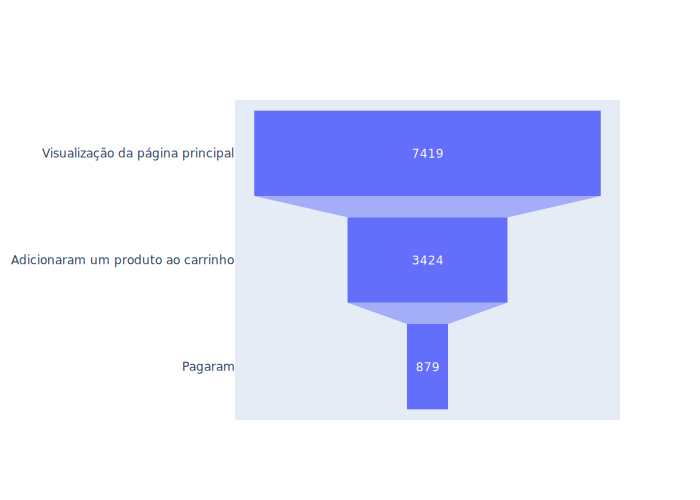

In [23]:
# Criando a figura
funnel_fig = go.Figure(go.Funnel(
    y=['Visualização da página principal', 'Adicionaram um produto ao carrinho', 'Pagaram'],
    x=[n_mainscreen, n_cartscreen, n_paymentsuccessful]
))

# Exibindo o funil
funnel_fig.show('svg')

Vemos como a parcela de usuários que chega a pagar é menor que a parcela que acessa o carrinho. Sem dúvida investigar a passagem entre essas etapas pode trazer bons resultados para a loja.

## O experimento ##

O experimento comparou a resposta dos usuários para duas opções de fonte no site. Além disso, foi realizado um teste A/A para verificar se o experimento funcionou corretamente. Os grupos do teste A/A têm os IDs 246 e 247, já o grupo B tem o ID 248. Vamos relembrar quantos usuários há em cada grupo:

In [24]:
data_['expid'].value_counts()

248    84563
246    79302
247    77022
Name: expid, dtype: int64

Para garantir que o experimentou funcionou corretamente precisamos testar se há uma diferença significativa entre os grupos A/A. Para isso, vamos utilizar um teste Mann-Whitney, que nos permite comparar as duas amostras e avaliar se a diferença é estatisticamente suficiente para considerarmos que sejam de populações distintas. Vamos começar criando um DataFrame apenas com os dados das compras concluídas e, em seguida, criando fatias dos dados contendo os grupos de cada um dos testes.

In [25]:
# Criando a tabela "orders_" com as linhas onde "eventname" é "PaymentScreenSuccessful"
orders_ = data_[data_['eventname'] == 'PaymentScreenSuccessful'].reset_index(drop=True)

# Criando a tabela "orders" apenas com as informações que precisaremos
orders = orders_[['deviceidhash', 'expid', 'date_time', 'date']]

# Criando a tabela dos grupos A, "ordersByUsersA1" e "ordersByUsersA2" e renomeando as colunas
ordersByUsersA1 = orders[orders['expid'] == 246].groupby('deviceidhash', as_index=False).agg({'date_time':'count'})
ordersByUsersA1.columns = ['deviceid', 'purchases']
ordersByUsersA2 = orders[orders['expid'] == 247].groupby('deviceidhash', as_index=False).agg({'date_time':'count'})
ordersByUsersA2.columns = ['deviceid', 'purchases']

Agora para realizar o teste Mann-Whitney precisamos criar duas amostras, ``sampleA1`` e ``sampleA2``, com o ID de cada usuário e seu o número de pedidos, que será 0 para os que não realizaram nenhum. Também precisamos criar uma tabela com as informações dos visitantes.

In [26]:
# Criando a tabela "visitors" e renomeando as colunas
visitors = (data_[data_['eventname'] == 'MainScreenAppear'].
             groupby(['date', 'expid'], as_index=False).agg({'date_time':'count'})
             .sort_values(by='expid').reset_index(drop=True))
visitors.columns = ['date', 'expid', 'visits']

# Criando a primeira amostra
sampleA1 = pd.concat([ordersByUsersA1['purchases'],
                     pd.Series(0, index=np.arange(
                         visitors[visitors['expid']== 246]['visits'].sum() - len(ordersByUsersA1['purchases'])), name='purchases')],
                    axis=0)

# Criando a segunda amostra
sampleA2 = pd.concat([ordersByUsersA2['purchases'],
                     pd.Series(0, index=np.arange(
                         visitors[visitors['expid']== 247]['visits'].sum() - len(ordersByUsersA2['purchases'])), name='purchases')],
                    axis=0)

Com nossas amostras criadas, podemos testar se há diferença estatística entre os grupos A:

In [27]:
'{:.3f}'.format(st.mannwhitneyu(sampleA1, sampleA2)[1])

'0.036'

Considerando um nível de signifiância de 0,05 (5%), como é o usual, não podemos afirmar que há diferença estatística entre os grupos, uma vez que o resultado do teste foi 0,072.

Vamos analisar agora se para o evento mais popular, o aparecimento da tela principal, há uma diferença estatística significativa entre os grupos. Para isso, vamos criar outra tabela apenas com os usuários que realizaram está ação. Depois, fatiaremos os dados para os grupos 246 e 247, nossos grupos de teste.

In [28]:
# Criando a tabela "mainscreen_" com as linhas onde "eventname" é "MainScreenAppear"
mainscreen_ = data_[data_['eventname'] == 'MainScreenAppear'].reset_index(drop=True)

# Criando a tabela "mainscreen" apenas com as informações que precisaremos
mainscreen = mainscreen_[['deviceidhash', 'expid', 'date_time', 'date']]

# Criando a tabela dos grupos A, "MainscreenUsersA1" e "MainscreenUsersA2" e renomeando as colunas
MainscreenUsersA1 = mainscreen[mainscreen['expid'] == 246].groupby('deviceidhash', as_index=False).agg({'date_time':'count'})
MainscreenUsersA1.columns = ['deviceid', 'mainscreen_views']
MainscreenUsersA2 = mainscreen[mainscreen['expid'] == 247].groupby('deviceidhash', as_index=False).agg({'date_time':'count'})
MainscreenUsersA2.columns = ['deviceid', 'mainscreen_views']

Vamos ver agora a quantidade de usuários que realizaram o carregamento da página principal:

In [29]:
print('Usuários do primeiro grupo de controle:', MainscreenUsersA1['deviceid'].nunique())
print('Usuários do segundo grupo de controle:', MainscreenUsersA2['deviceid'].nunique())
print('_____________________________________________________________')

Usuários do primeiro grupo de controle: 2450
Usuários do segundo grupo de controle: 2476
_____________________________________________________________


Temos números bem próximos entre os usuários que carregaram a página principal nos dois grupos de controle: a diferença é de apenas 26 usuários. Agora vamos calcular a proporção que esses usuários representam dos usuários totais em cada grupo.

In [30]:
print('Proporção de usuários do primeiro grupo de controle: {:.2f}%'.format(
    (MainscreenUsersA1['deviceid'].nunique()/data_[data_['expid']==246]['deviceidhash'].nunique())*100))
print('Proporção de usuários do segundo grupo de controle: {:.2f}%'.format(
    (MainscreenUsersA2['deviceid'].nunique()/data_[data_['expid']==247]['deviceidhash'].nunique())*100))
print('_____________________________________________________________')

Proporção de usuários do primeiro grupo de controle: 98.63%
Proporção de usuários do segundo grupo de controle: 98.53%
_____________________________________________________________


A diferença da proporção entre os grupos é bem pequena, cerca de 0,1%. Agora, vamos conferir se essa diferença é estatisticamente significante:

In [31]:
# Criando a primeira amostra
sampleA1_2 = pd.concat([MainscreenUsersA1['mainscreen_views'],
                     pd.Series(0, index=np.arange(
                         data_[data_['expid']== 246]['deviceidhash'].nunique() - len(MainscreenUsersA1['mainscreen_views'])), name='mainscreen_views')],
                    axis=0)

# Criando a segunda amostra
sampleA2_2 = pd.concat([MainscreenUsersA2['mainscreen_views'],
                     pd.Series(0, index=np.arange(
                         data_[data_['expid']== 247]['deviceidhash'].nunique() - len(MainscreenUsersA2['mainscreen_views'])), name='mainscreen_views')],
                    axis=0)

# Realizando o teste
'{:.3f}'.format(st.mannwhitneyu(sampleA1_2, sampleA2_2)[1])

'0.358'

Como o valor P do teste é bem maior que 0,05, nosso nível mínimo de significância, podemos afirmar que as duas amostras não tem diferença estatística significativa em relação a proporção de acessos a página principal.

Vamos testar se isso se repete para os outros eventos. Para isso, criaremos um loop for para agilizar o processo.

In [32]:
# Criando a lista de eventos que serão passados para o loop
events = data_['eventname'].unique()

# Criando o loop
for event in events:
    event_df = data_[data_['eventname'] == event].reset_index(drop=True)
    event_df = event_df[['deviceidhash', 'expid', 'date_time', 'date']]
    eventUsersA1 = event_df[event_df['expid'] == 246].groupby('deviceidhash', as_index=False).agg({'date_time':'count'})
    eventUsersA1.columns = ['deviceid', 'event_count']
    eventUsersA2 = event_df[event_df['expid'] == 247].groupby('deviceidhash', as_index=False).agg({'date_time':'count'})
    eventUsersA2.columns = ['deviceid', 'event_count']
    usersA1 = eventUsersA1['deviceid'].nunique()
    usersA2 = eventUsersA2['deviceid'].nunique()
    usersA1Prop = (eventUsersA1['deviceid'].nunique()/data_[data_['expid']==246]['deviceidhash'].nunique())*100
    usersA2Prop = (eventUsersA2['deviceid'].nunique()/data_[data_['expid']==247]['deviceidhash'].nunique())*100
    sampleA1_loop = pd.concat([eventUsersA1['event_count'],
                     pd.Series(0, index=np.arange(
                         data_[data_['expid']== 246]['deviceidhash'].nunique() - len(eventUsersA1['event_count'])), name='events')],
                    axis=0)
    sampleA2_loop = pd.concat([eventUsersA2['event_count'],
                     pd.Series(0, index=np.arange(
                         data_[data_['expid']== 247]['deviceidhash'].nunique() - len(eventUsersA2['event_count'])), name='events')],
                    axis=0)
    print('Quantidade de usuários para o evento {evento} no primeiro grupo: {users}'.format(evento=event, users=usersA1))
    print('Quantidade de usuários para o evento {evento} no segundo grupo: {users}'.format(evento=event, users=usersA2))
    print()
    print('Proporções de usuários para o evento {evento} no primeiro grupo: {usersp:.2f}%'.format(evento=event, usersp=usersA1Prop))
    print('Proporções de usuários para o evento {evento} no segundo grupo: {usersp:.2f}%'.format(evento=event, usersp=usersA2Prop))
    print()
    print('Valor P da diferença entre as amostras dos grupos: {:.3f}'.format(st.mannwhitneyu(sampleA1_loop, sampleA2_loop)[1]))
    print('_____________________________________________________________')
    print()

Quantidade de usuários para o evento Tutorial no primeiro grupo: 278
Quantidade de usuários para o evento Tutorial no segundo grupo: 283

Proporções de usuários para o evento Tutorial no primeiro grupo: 11.19%
Proporções de usuários para o evento Tutorial no segundo grupo: 11.26%

Valor P da diferença entre as amostras dos grupos: 0.460
_____________________________________________________________

Quantidade de usuários para o evento MainScreenAppear no primeiro grupo: 2450
Quantidade de usuários para o evento MainScreenAppear no segundo grupo: 2476

Proporções de usuários para o evento MainScreenAppear no primeiro grupo: 98.63%
Proporções de usuários para o evento MainScreenAppear no segundo grupo: 98.53%

Valor P da diferença entre as amostras dos grupos: 0.358
_____________________________________________________________

Quantidade de usuários para o evento OffersScreenAppear no primeiro grupo: 1542
Quantidade de usuários para o evento OffersScreenAppear no segundo grupo: 1520

Pr

O resultado que obtivemos é que todos nenhum dos eventos apresenta diferença estatística entre os grupos de controle, o que indica que os mecanismos utilizados no teste funcionaram corretamente. Podemos ver também que as diferenças de usuários únicos em cada evento é bastante similar entre os grupos, tanto na diferença total quanto porporcional.

Vamos repetir esse mesmo processo, porém agora comparando os resultados combinados dos grupos A/A com os resultados do grupo B. Vamos calcular a quantidade de usuários em cada evento, sua proporção dos usuários totais e a significância estatística das diferenças.

In [33]:
# Criando o loop
for event in events:
    event_df = data_[data_['eventname'] == event].reset_index(drop=True)
    event_df = event_df[['deviceidhash', 'expid', 'date_time', 'date']]
    eventUsersA = event_df.loc[(event_df['expid'] == 246) | (event_df['expid'] == 247)].groupby('deviceidhash', as_index=False).agg({'date_time':'count'})
    eventUsersA.columns = ['deviceid', 'event_count']
    eventUsersB = event_df[event_df['expid'] == 248].groupby('deviceidhash', as_index=False).agg({'date_time':'count'})
    eventUsersB.columns = ['deviceid', 'event_count']
    usersA = eventUsersA['deviceid'].nunique()
    usersB = eventUsersB['deviceid'].nunique()
    usersAProp = (eventUsersA['deviceid'].nunique()/data_.loc[(data_['expid']==246) | (data_['expid']==247)]['deviceidhash'].nunique())*100
    usersBProp = (eventUsersB['deviceid'].nunique()/data_[data_['expid']==248]['deviceidhash'].nunique())*100
    sampleA_loop = pd.concat([eventUsersA['event_count'],
                     pd.Series(0, index=np.arange(
                         data_.loc[(data_['expid']== 246) | (data_['expid']==247)]['deviceidhash'].nunique() - len(eventUsersA['event_count'])), name='events')],
                    axis=0)
    sampleB_loop = pd.concat([eventUsersB['event_count'],
                     pd.Series(0, index=np.arange(
                         data_[data_['expid']== 248]['deviceidhash'].nunique() - len(eventUsersB['event_count'])), name='events')],
                    axis=0)
    print('Quantidade de usuários para o evento {evento} no grupo A: {users}'.format(evento=event, users=usersA))
    print('Quantidade de usuários para o evento {evento} no grupo B: {users}'.format(evento=event, users=usersB))
    print()
    print('Proporções de usuários para o evento {evento} no grupo A: {usersp:.2f}%'.format(evento=event, usersp=usersAProp))
    print('Proporções de usuários para o evento {evento} no grupo B: {usersp:.2f}%'.format(evento=event, usersp=usersBProp))
    print()
    print('Valor P da diferença entre as amostras dos grupos A e B: {:.3f}'.format(st.mannwhitneyu(sampleA_loop, sampleB_loop)[1]))
    print('_____________________________________________________________')
    print()

Quantidade de usuários para o evento Tutorial no grupo A: 561
Quantidade de usuários para o evento Tutorial no grupo B: 279

Proporções de usuários para o evento Tutorial no grupo A: 11.23%
Proporções de usuários para o evento Tutorial no grupo B: 11.00%

Valor P da diferença entre as amostras dos grupos A e B: 0.399
_____________________________________________________________

Quantidade de usuários para o evento MainScreenAppear no grupo A: 4926
Quantidade de usuários para o evento MainScreenAppear no grupo B: 2493

Proporções de usuários para o evento MainScreenAppear no grupo A: 98.58%
Proporções de usuários para o evento MainScreenAppear no grupo B: 98.27%

Valor P da diferença entre as amostras dos grupos A e B: 0.081
_____________________________________________________________

Quantidade de usuários para o evento OffersScreenAppear no grupo A: 3062
Quantidade de usuários para o evento OffersScreenAppear no grupo B: 1531

Proporções de usuários para o evento OffersScreenAppear

A diferença de proporção entre os grupos A e B é bem similar, com o grupo A sendo levemente superior. Porém, se considerarmos um nível de significância mínina de 0,05, nenhum dos eventos atingiu diferença estatística entre os grupos. Isso nos impede de rejeitar a hipótese nula: ou seja, de que os dois grupos tem médias iguais.

Para os testes que realizamos, 12 no total, consideramos o grau de significância de 0,05, caso tivéssemos optado por um grau diferente, 0,1 por exemplo, ainda assim teríamos que rejeitar a hipótese das amostras terem médias diferentes.

# Conclusão #

Segundo nossa investigação, há algumas possibilidades de rotas para os usuários. No caminho que escolhemos para calcular o funil de vendas, uma grande parcela dos usuários que chegam ao carrinho de compras não chega a pagar seus pedidos. Apenas 25,7% dos usuários que chegaram ao carrinho pagaram suas compras. Logo, rever os passos entre o carrinho e o pagamento e reforçar as estratégias para relembrar os usuários dos produtos adicionados são estratégias que podem trazer resultados positivos para a loja.

Nossa análise apontou que teste A/A/B foi realizado de forma correta, com o teste A/A segundo estatísticamente válido. Porém, a partir dos testes de hipóteses que realizamos, comparando cada um dos eventos registrados, a alteração da fonte testada não resultou em diferenças estatísticamente significativas. Esse resultado permanece igual mesmo considerando-se um nível de significância mais amplo, como de 0,1.